In [1]:
library(ape)
library(sitePath)

Warning message:
"package 'sitePath' was built under R version 3.6.3"


In [2]:
# data(h3n2_align)
# data(h3n2_tree)

# tree <- addMSA(h3n2_tree, alignment = h3n2_align)
# paths <- lineagePath(tree, similarity = 0.023)
# plot(paths)

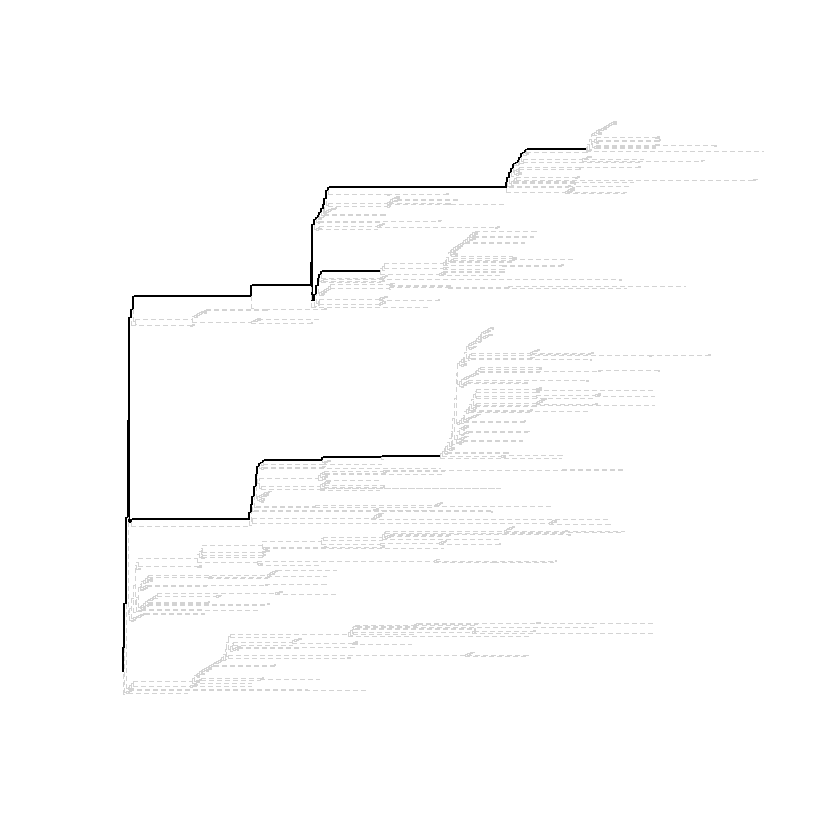

In [3]:
tree <- read.tree(file.path("Trees", "SARS_CoV_2_cds", "RAxML_bestTree.GTRGAMMA"))
tree <- addMSA(tree, msaPath = file.path("Trees", "SARS_CoV_2_cds", "aligned.fasta"), msaFormat = "fasta")

paths <- lineagePath(tree, similarity = 0.03)
plot(paths)

In [4]:
fixationlineages <- function (paths,
                              minEffectiveSize = NULL,
                              searchDepth = 1,
                              method = c("compare", "insert", "delete"),
                              ...) {
    tree <- attr(paths, "tree")
    nTips <- length(tree[["tip.label"]])
    align <- attr(paths, "align")
    # Generate the site mapping from reference
    reference <- attr(paths, "reference")
    # Decide which miniminzing strategy
    minimizeEntropy <- switch(
        match.arg(method),
        "compare" = sitePath:::minEntropyByComparing,
        "insert" = sitePath:::minEntropyByInserting,
        "delete" = sitePath:::minEntropyByDeleting
    )
    # Get the 'minEffectiveSize' for each fixation
    if (is.null(minEffectiveSize)) {
        minEffectiveSize <- nTips / length(unique(unlist(paths)))
    } else if (!is.numeric(minEffectiveSize)) {
        stop("\"minEffectiveSize\" only accepts numeric")
    }
    minEffectiveSize <- ceiling(minEffectiveSize)
    # Get the 'searchDepth' for heuristic search
    if (searchDepth < 1) {
        stop("\"searchDepth\" should be at least 1")
    } else {
        searchDepth <- ceiling(searchDepth)
    }
    divNodes <- sitePath:::divergentNode(paths)
    nodeAlign <- sitePath:::.tipSeqsAlongPathNodes(
        paths = paths,
        divNodes = divNodes,
        tree = tree,
        align = align
    )
    res <- sitePath:::.findFixationSite(
        paths = paths,
        tree = tree,
        align = align,
        nodeAlign = nodeAlign,
        divNodes = divNodes,
        reference = reference,
        minimizeEntropy = minimizeEntropy,
        minEffectiveSize = minEffectiveSize,
        searchDepth = searchDepth
    )
    attr(res, "paths") <- paths
    attr(res, "reference") <- reference
    class(res) <- "fixationSites"
    return(res)
}

In [5]:
mutations <- fixationlineages(paths, method = "insert")

In [6]:
groupByPath <- lapply(paths, function (p) {
    terminalTips <- sitePath:::.childrenTips(tree, p[length(p)])
    # Group fixation results by path rather than site
    group <- list()
    for (sp in mutations) {
        site <- attr(sp, "site")
        for (mp in sp) {
            tips <- mp[[length(mp)]]
            # Filter if not belong to the path
            if (all(terminalTips %in% tips)) {
                toAdd <- lapply(mp, function (tips) {
                    siteChar <- attr(tips, "AA")
                    attributes(tips) <- NULL
                    attr(tips, "site") <- siteChar
                    names(attr(tips, "site")) <- site
                    tips
                })
                group <- c(group, list(toAdd))
            }
        }
    }
    # Group tips according to fixation points
    res <- group[[1]]
    for (p in group[-1]) {
        for (tips in p) {
            site <- attr(tips, "site")
            # Update grouping for each tips by growing a new list
            newGrouping <- list()
            for (i in seq_along(res)) {
                gp <- res[[i]]
                common <- sort(intersect(tips, gp))
                if (length(common) == 0) {
                    newGrouping <- res[1:i]
                } else if (identical(sort(gp), sort(tips))) {
                    attr(gp, "site") <- c(attr(gp, "site"), site)
                    if (i + 1 <= length(res)) {
                        trailing <- res[(i + 1):length(res)]
                    } else {
                        trailing <- list()
                    }
                    newGrouping <- c(newGrouping, list(gp), trailing)
                    break
                } else {
                    if (identical(sort(gp), common)) {
                        # The new coming tips includes the current group
                        # The extra tips stay for the next loop
                        tips <- setdiff(tips, gp)
                        # Update the SNP site info for the current group
                        attr(gp, "site") <- c(attr(gp, "site"), site)
                        newGrouping <- c(newGrouping, list(gp))
                    } else if (identical(sort(tips), common)) {
                        # The new coming tips are included in the group (they are used up at this point)
                        separate <- setdiff(gp, tips)
                        attributes(separate) <- attributes(gp)
                        attr(tips, "site") <- c(attr(gp, "site"), site)
                        if (i + 1 <= length(res)) {
                            trailing <- res[(i + 1):length(res)]
                        } else {
                            trailing <- list()
                        }
                        newGrouping <- c(newGrouping, list(tips), list(separate), trailing)
                        # Go for the next new coming tips
                        break
                    } else {
                        stop("Something's not right")
                    }
                }
            }
            # The new coming tips are used up and update the grouping
            res <- newGrouping
        }
    }
    return(res)
})

In [7]:
groupingSNP <- lapply(groupByPath, function (gp) {
    # Prep for growing the tree
    # Define the first node and the first tip cluster
    newParentNode <- length(gp) + 1L # Keep track of the newly added internal nodes
    tipNode <- 1L
    currentTips <- gp[[tipNode]]
    attr(currentTips, "snpSites") <- character()
    tipClusters <- list(currentTips) # The existing tips in the tree
    refSites <- attr(currentTips, "site")
    
    # Define the first edge of the tree
    parentNodes <- newParentNode
    childrenNodes <- tipNode
    edgeSNPs <- list(character())
    # A list to record the fixation sites of the parent nodes
    parentNodesSites <- list()
    parentNodesSites[[as.character(newParentNode)]] <- refSites
    
    # Grow the tree
    for (tipNode in seq_along(gp)[-1]) {
        currentTips <- gp[[tipNode]]
        currentSites <- attr(currentTips, "site")
        # Attach the tip near the most related tips
        # Assume the reference tips are the most related (least number of SNP)
        mostRelatedTipNode <- 1L
        leastSNPnum <- sum(refSites != currentSites)
        # Loop through the rest existing tip clusters
        for (otherTipNode in seq_along(tipClusters)[-1]) {
            otherSites <- attr(tipClusters[[otherTipNode]], "site")
            snpNum <- sum(otherSites != currentSites)
            if (snpNum < leastSNPnum) {
                mostRelatedTipNode <- otherTipNode
                leastSNPnum <- snpNum
            }
        }
        # Find the direct tree edge to the most related tips
        edgeIndex <- which(childrenNodes == mostRelatedTipNode)
        parentNode <- parentNodes[edgeIndex]
        # Tree growing differs according to the SNP against parent node and edge SNP
        parentSites <- parentNodesSites[[as.character(parentNode)]]
        snpSites <- as.character(na.omit(vapply(
            X = names(parentSites),
            FUN = function (site) {
                ref <- parentSites[site]
                snp <- currentSites[site]
                if (ref == snp) {
                    return(NA_character_)
                }
                return(paste0(ref, site, snp))
            },
            FUN.VALUE = character(1)
        )))
        edgeSNP <- edgeSNPs[[edgeIndex]]
        sharedWithEdgeSNP <- intersect(snpSites, edgeSNP)
        # A new internal node is needed when no SNP overlap 
        if (length(sharedWithEdgeSNP) != 0) {
            newParentNode <- newParentNode + 1L
            # Insert the new internal node to the target edge
            parentNodes[edgeIndex] <- newParentNode
            parentNodes <- c(parentNodes, parentNode)
            childrenNodes <- c(childrenNodes, newParentNode)
            edgeSNPs <- c(edgeSNPs, list(sharedWithEdgeSNP))
            # Update the SNP of the directly linked edge to the most related tips
            edgeSNPs[[edgeIndex]] <- setdiff(edgeSNP, sharedWithEdgeSNP)
            # Calculate the site for the new internal node
#             siteToChange <- as.character(regmatches(sharedWithEdgeSNP, regexpr('[0-9]+', sharedWithEdgeSNP)))
            siteToChange <- substr(sharedWithEdgeSNP, 2, nchar(sharedWithEdgeSNP) - 1)
            parentSites[siteToChange] <- substr(sharedWithEdgeSNP, nchar(sharedWithEdgeSNP), nchar(sharedWithEdgeSNP))
            parentNodesSites[[as.character(newParentNode)]] <- parentSites
            # Update the parent node and edge SNP for the current tip node
            parentNode <- newParentNode
            snpSites <- setdiff(snpSites, sharedWithEdgeSNP)
        }
        # Add edge
        parentNodes <- c(parentNodes, parentNode)
        childrenNodes <- c(childrenNodes, tipNode)
        # Add edge SNP
        edgeSNPs <- c(edgeSNPs, list(snpSites))
        # Add the current tips
        tipClusters <- c(tipClusters, list(currentTips))
    }
    res <- list(
        "edge" = cbind(parentNodes, childrenNodes),
        "edge.length" = lengths(edgeSNPs) + 0.05,
        "Nnode" = length(unique(parentNodes)),
        "tip.label" = as.character(lengths(gp))
    )
    attr(res, "tipClusters") <- tipClusters
    attr(res, "edgeSNPs") <- edgeSNPs
    class(res) <- "phylo"
    return(res)
})

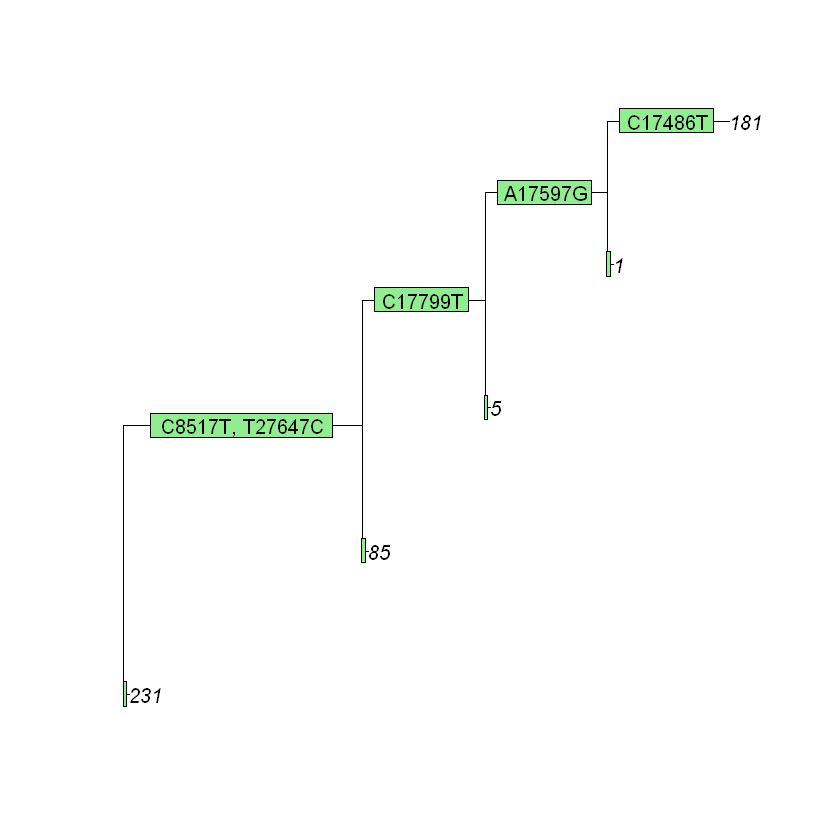

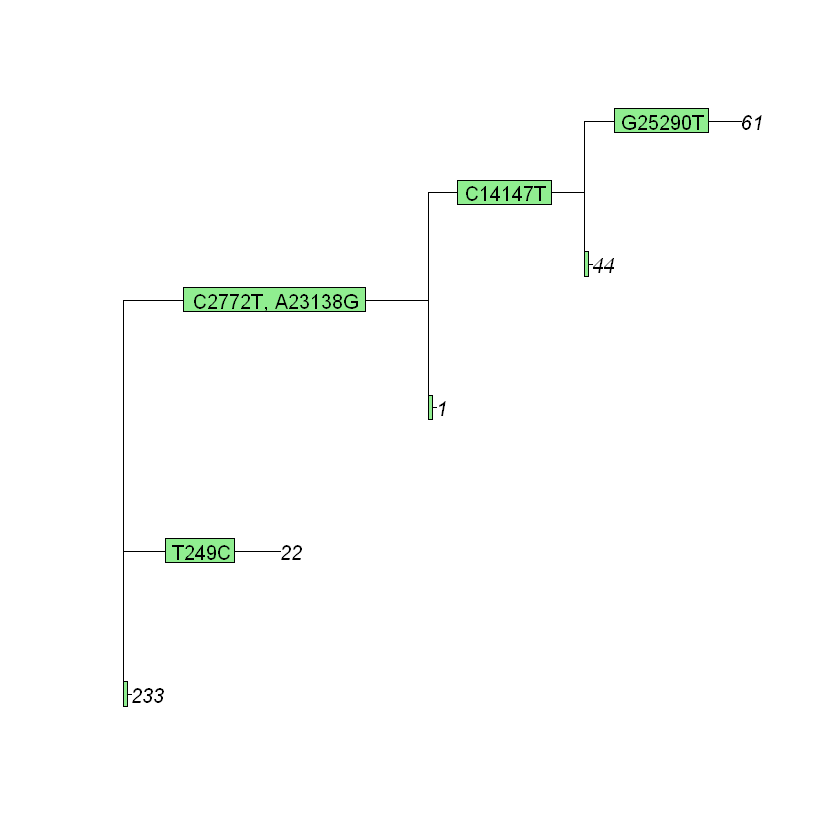

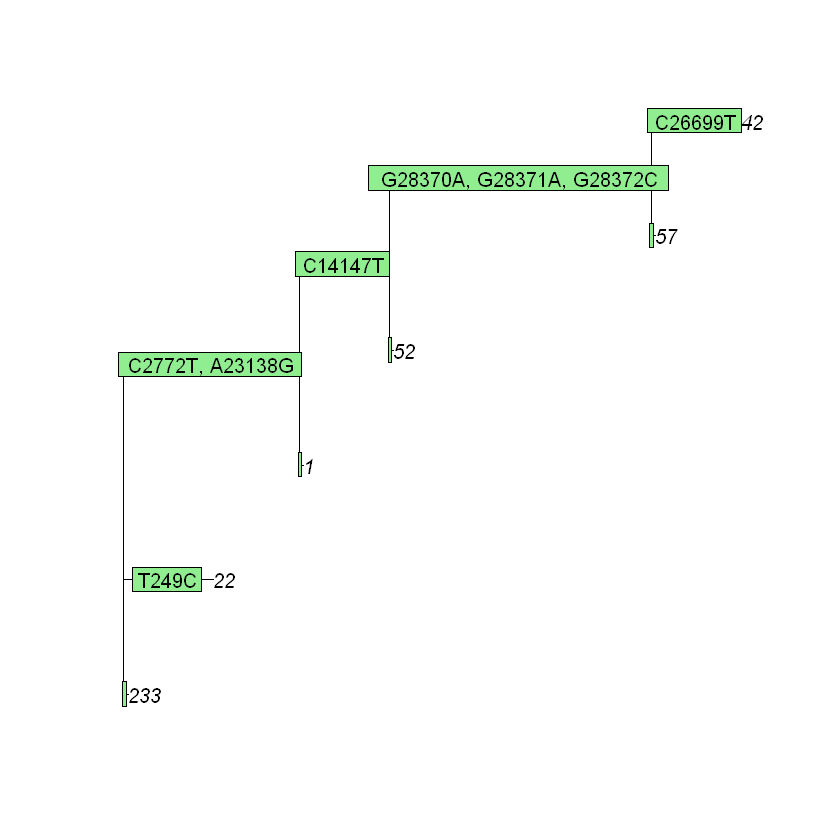

In [8]:
for (i in seq_along(paths)) {
    plot.phylo(groupingSNP[[i]])
    edgelabels(vapply(attr(groupingSNP[[i]], "edgeSNPs"), paste, collapse = ", ", FUN.VALUE = character(1)))
}

In [9]:
grouping <- list(groupByPath[[1]])

for (gpIndex in seq_along(groupByPath)[-1]) {
    gp <- groupByPath[[gpIndex]]
    toMergeIndex <- NULL
    divergedIndex <- 0L
    # Loop through to find the most related group
    for (i in seq_along(grouping)) {
        allTips <- unlist(grouping[[i]])
        for (j in seq_along(gp)[-1]) {
            if (all(!gp[[j]] %in% allTips)) {
                m <- i
                d <- j
                break
            }
        }
        if (d > divergedIndex) {
            toMergeIndex <- m
            divergedIndex <- d
        }
    }
    # Find the tips before diverged
    sharedTips <- gp[[divergedIndex - 1]]
    refSites <- attr(sharedTips, "site")
    # The non-shared part
    divergedTips <- setdiff(sharedTips, allTips)
    attr(divergedTips, "site") <- refSites
    # Drop the overlapped part
    grouping[[gpIndex]] <- c(list(divergedTips), gp[divergedIndex:length(gp)])
    # Find the most related group
    toMerge <- grouping[[toMergeIndex]]
    # To determine where to add the new (truncated) group
    for (i in seq_along(toMerge)) {
        gpTips <- unlist(gp)
        if (all(!toMerge[[i]] %in% gpTips)) {
            # Find the tips before diverged
            sharedTips <- toMerge[[i - 1]]
            sites <- attr(sharedTips, "site")
            # The non-shared part
            divergedTips <- setdiff(sharedTips, gpTips)
            attr(divergedTips, "site") <- sites
            # The shared part
            sharedTips <- setdiff(sharedTips, divergedTips)
            attr(sharedTips, "site") <- sites
            attr(sharedTips, "toMerge") <- gpIndex
            attr(sharedTips, "toMergeRefSites") <- refSites
            # Reform
            if (i == 2) {
                preTips <- list()
            } else {
                preTips <- toMerge[1:(i - 2)]
            }
            grouping[[toMergeIndex]] <- c(
                preTips,
                list(sharedTips),
                list(divergedTips),
                toMerge[i:length(toMerge)]
            )
            break
        }
    }
}

In [10]:
# The existing tips in the tree
tipClusters <- list()
# The edges and its SNP of the tree
parentNodes <- integer()
childrenNodes <- integer()
edgeSNPs <- list()

# Keep track of the newly added internal node
newParentNode <- length(unlist(grouping, recursive = FALSE)) + 1L
parentNode <- newParentNode
# Keep track of the newly added tip node
tipNode <- 0L
# A list to record the fixation sites of the parent nodes
parentNodesSites <- list()

for (gpIndex in seq_along(grouping)) {
    # The group to add onto the tree
    gp <- grouping[[gpIndex]]
    
    # The initial tips of the group
    currentTips <- gp[[1]]
    # Assume the initial reference site
    refSites <- attr(currentTips, "site")
    # Find where to merge and parent node, update reference site maybe
    for (i in seq_along(tipClusters)) {
        toMerge <- tipClusters[[i]]
        toMergeIndex <- attr(toMerge, "toMerge")
        if (!is.null(toMergeIndex) && toMergeIndex == gpIndex) {
            refSites <- attr(toMerge, "toMergeRefSites")
            parentNode <- parentNodes[which(childrenNodes == i)]
            break
        }
    }
    parentNodesSites[[as.character(parentNode)]] <- refSites
    
    # Track the tip and internal node
    tipNode <- tipNode + 1L
    startingNode <- tipNode
    tipClusters <- c(tipClusters, list(currentTips))
    # Define the initial edge of the group
    parentNodes <- c(parentNodes, parentNode)
    childrenNodes <- c(childrenNodes, tipNode)
    # SNP of the initial edge is set none
    edgeSNPs <- c(edgeSNPs, list(character()))
    
    # Grow the tree
    for (tipIndex in seq_along(gp)[-1]) {
        tipNode <- tipNode + 1L
        currentTips <- gp[[tipIndex]]
        currentSites <- attr(currentTips, "site")
        # Attach the tip near the most related tips
        # Assume the reference tips are the most related (least number of SNP)
        mostRelatedTipNode <- startingNode
        leastSNPnum <- sum(refSites != currentSites)
        # Loop through the rest existing tip clusters
        for (otherTipNode in seq_along(tipClusters)[-seq_len(startingNode)]) {
            otherSites <- attr(tipClusters[[otherTipNode]], "site")
            snpNum <- sum(otherSites != currentSites)
            if (snpNum < leastSNPnum) {
                mostRelatedTipNode <- otherTipNode
                leastSNPnum <- snpNum
            }
        }
        # Find the direct tree edge to the most related tips
        edgeIndex <- which(childrenNodes == mostRelatedTipNode)
        parentNode <- parentNodes[edgeIndex]
        # Tree growing differs according to the SNP against parent node and edge SNP
        parentSites <- parentNodesSites[[as.character(parentNode)]]
        snpSites <- as.character(na.omit(vapply(
            X = names(parentSites),
            FUN = function (site) {
                ref <- parentSites[site]
                snp <- currentSites[site]
                if (ref == snp) {
                    return(NA_character_)
                }
                return(paste0(ref, site, snp))
            },
            FUN.VALUE = character(1)
        )))
        edgeSNP <- edgeSNPs[[edgeIndex]]
        sharedWithEdgeSNP <- intersect(snpSites, edgeSNP)
        # A new internal node is needed when no SNP overlap 
        if (length(sharedWithEdgeSNP) != 0) {
            newParentNode <- newParentNode + 1L
            # Insert the new internal node to the target edge
            parentNodes[edgeIndex] <- newParentNode
            parentNodes <- c(parentNodes, parentNode)
            childrenNodes <- c(childrenNodes, newParentNode)
            edgeSNPs <- c(edgeSNPs, list(sharedWithEdgeSNP))
            # Update the SNP of the directly linked edge to the most related tips
            edgeSNPs[[edgeIndex]] <- setdiff(edgeSNP, sharedWithEdgeSNP)
            # Calculate the site for the new internal node
#             siteToChange <- as.character(regmatches(sharedWithEdgeSNP, regexpr('[0-9]+', sharedWithEdgeSNP)))
            siteToChange <- substr(sharedWithEdgeSNP, 2, nchar(sharedWithEdgeSNP) - 1)
            parentSites[siteToChange] <- substr(sharedWithEdgeSNP, nchar(sharedWithEdgeSNP), nchar(sharedWithEdgeSNP))
            parentNodesSites[[as.character(newParentNode)]] <- parentSites
            # Update the parent node and edge SNP for the current tip node
            parentNode <- newParentNode
            snpSites <- setdiff(snpSites, sharedWithEdgeSNP)
        }
        # Add edge
        parentNodes <- c(parentNodes, parentNode)
        childrenNodes <- c(childrenNodes, tipNode)
        # Add edge SNP
        edgeSNPs <- c(edgeSNPs, list(snpSites))
        # Add the current tips
        tipClusters <- c(tipClusters, list(currentTips))
    }
}
res <- list(
    "edge" = cbind(parentNodes, childrenNodes),
    "edge.length" = lengths(edgeSNPs) + 0.05,
    "Nnode" = length(unique(parentNodes)),
    "tip.label" = as.character(lengths(unlist(grouping, recursive = FALSE)))
)
attr(res, "tipClusters") <- tipClusters
attr(res, "edgeSNPs") <- edgeSNPs
class(res) <- "phylo"

In [11]:
checkValidPhylo(res)

Starting checking the validity of res...
Found number of tips: n = 15 
Found number of nodes: m = 7 
Done.


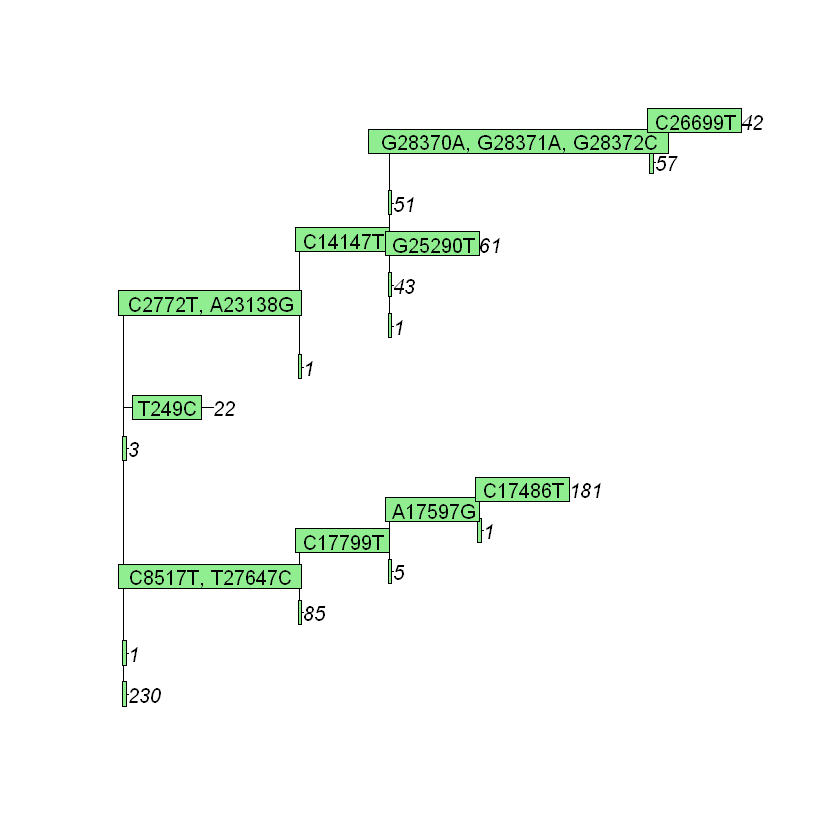

In [12]:
plot(res)
edgelabels(vapply(attr(res, "edgeSNPs"), paste, collapse = ", ", FUN.VALUE = character(1)))